In [1]:
import torch, sys
sys.path.append("../")
from ad_utils import *
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, auc, classification_report, roc_auc_score
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import pandas as pd
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda1
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")

data = np.load("../../hvcm/RFQ.npy", allow_pickle=True)
label = np.load("../../hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

normal_data = data[label == 0]
faulty_data = data[label == 1]

normal_label = label[label == 0]
faulty_label = label[label == 1]

X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(normal_data, normal_label, test_size=0.2, random_state=42, shuffle=True)
X_train_faulty, X_test_faulty, y_train_faulty, y_test_faulty = train_test_split(faulty_data, faulty_label, test_size=0.2, random_state=42, shuffle=True)

NVIDIA A30
(872, 4500, 14) (872,)


# Conditional GAN

In [2]:
# Enhanced Conv1D Generator for Time Series
class Conv1DConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=2, num_features=14, seq_len=4500):
        super(Conv1DConditionalGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.num_features = num_features
        self.seq_len = seq_len
        
        # Optimized label embedding for sensor data
        self.label_emb = nn.Embedding(num_classes, 64)
        
        # Optimized initial size for 4500 sequence length
        self.init_size = 71  # 71 * 64 = 4544 ≈ 4500
        input_dim = latent_dim + 64  # latent + label embedding
        
        # Enhanced initial projection for temporal data
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512 * self.init_size),
            nn.BatchNorm1d(512 * self.init_size),
            nn.ReLU(inplace=True)
        )
        
        # Optimized Conv1D upsampling for sensor patterns
        self.conv_blocks = nn.Sequential(
            # Block 1: 512 -> 256 channels (71 -> 142)
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            
            # Block 2: 256 -> 128 channels (142 -> 284)
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            
            # Block 3: 128 -> 64 channels (284 -> 568)
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            
            # Block 4: 64 -> 32 channels (568 -> 1136)
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            
            # Block 5: 32 -> 16 channels (1136 -> 2272)
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),
            
            # Final block: 16 -> 14 channels (2272 -> 4544)
            nn.ConvTranspose1d(16, num_features, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, z, labels):
        # Embed labels
        label_emb = self.label_emb(labels)
        
        # Concatenate noise and label embedding
        gen_input = torch.cat((z, label_emb), dim=1)
        
        # Project to initial size
        out = self.fc(gen_input)
        out = out.view(out.shape[0], 512, self.init_size)
        
        # Apply conv blocks
        out = self.conv_blocks(out)
        
        # Precise adjustment to 4500 length
        if out.shape[2] != self.seq_len:
            out = nn.functional.interpolate(out, size=self.seq_len, mode='linear', align_corners=False)
        
        # Transpose to (batch_size, seq_len, num_features)
        return out.transpose(1, 2)

# Enhanced Conv1D Discriminator for Time Series
class Conv1DConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes=2, num_features=14, seq_len=4500):
        super(Conv1DConditionalDiscriminator, self).__init__()
        self.num_classes = num_classes
        self.num_features = num_features
        self.seq_len = seq_len
        
        # Optimized label embedding for sensor discrimination
        self.label_emb = nn.Embedding(num_classes, 64)
        self.label_proj = nn.Linear(64, seq_len)
        
        # Optimized Conv1D blocks for sensor feature extraction
        self.conv_blocks = nn.Sequential(
            # Input: (14 + 1) channels, 4500 length
            nn.utils.spectral_norm(nn.Conv1d(num_features + 1, 32, kernel_size=8, stride=2, padding=3)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
            
            # 2250 length
            nn.utils.spectral_norm(nn.Conv1d(32, 64, kernel_size=8, stride=2, padding=3)),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
            
            # 1125 length
            nn.utils.spectral_norm(nn.Conv1d(64, 128, kernel_size=8, stride=2, padding=3)),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            
            # 562 length
            nn.utils.spectral_norm(nn.Conv1d(128, 256, kernel_size=8, stride=2, padding=3)),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            
            # 281 length
            nn.utils.spectral_norm(nn.Conv1d(256, 512, kernel_size=8, stride=2, padding=3)),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Optimized classifier for sensor data
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.utils.spectral_norm(nn.Linear(512, 256)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Linear(256, 1))
        )
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        
        # Embed and project labels
        label_emb = self.label_emb(labels)
        label_seq = self.label_proj(label_emb).unsqueeze(1)
        
        # Transpose x to (batch_size, num_features, seq_len)
        x = x.transpose(1, 2)
        
        # Concatenate data and label
        x_labeled = torch.cat([x, label_seq], dim=1)
        
        # Apply conv blocks
        features = self.conv_blocks(x_labeled)
        
        # Classify
        output = self.classifier(features)
        
        return output

# Enhanced training function with improved stability
def train_conditional_gan_conv1d(normal_data, normal_labels, device, epochs=50, batch_size=64, lr_g=0.0002, lr_d=0.0001):
    """
    Train Conditional GAN optimized for sensor time series data
    """
    print(f"Training data shape: {normal_data.shape}")
    print(f"Labels shape: {normal_labels.shape}")
    
    # Model parameters
    latent_dim = 128  # Increased for complex sensor patterns
    num_classes = 2
    num_features = normal_data.shape[-1]
    seq_len = normal_data.shape[1]
    
    print(f"Model parameters: latent_dim={latent_dim}, num_classes={num_classes}, num_features={num_features}, seq_len={seq_len}")
    
    # Initialize models
    generator = Conv1DConditionalGenerator(latent_dim, num_classes, num_features, seq_len).to(device)
    discriminator = Conv1DConditionalDiscriminator(num_classes, num_features, seq_len).to(device)
    
    # Optimized weight initialization for sensor data
    def weights_init(m):
        if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d)):
            nn.init.xavier_normal_(m.weight, gain=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight, gain=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.constant_(m.bias, 0)
    
    generator.apply(weights_init)
    discriminator.apply(weights_init)
    
    # Balanced optimizers for sensor data - FIXED: More balanced learning rates
    optimizer_G = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_d * 0.5, betas=(0.5, 0.999))  # Reduce D learning rate
    
    # Loss function
    criterion = nn.BCEWithLogitsLoss()
    
    # Create dataloader with optimized batch size
    dataset = TensorDataset(
        torch.tensor(normal_data, dtype=torch.float32),
        torch.tensor(normal_labels, dtype=torch.long)
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    print("Starting optimized Conditional GAN training for sensor data...")
    
    # Training history
    d_losses = []
    g_losses = []
    
    for epoch in range(epochs):
        epoch_d_losses = []
        epoch_g_losses = []
        
        for i, (real_data, real_labels) in enumerate(dataloader):
            real_data = real_data.to(device)
            real_labels = real_labels.to(device)
            current_batch_size = real_data.size(0)
            
            # FIXED: Stronger label smoothing for sensor data
            valid = torch.ones(current_batch_size, 1, device=device) * (0.8 + 0.1 * torch.rand(current_batch_size, 1, device=device))
            fake = torch.zeros(current_batch_size, 1, device=device) + (0.2 * torch.rand(current_batch_size, 1, device=device))
            
            # FIXED: Train Discriminator less frequently (every 3 iterations for balance)
            if i % 3 == 0:
                optimizer_D.zero_grad()
                
                # Add noise to real data for robustness
                noise_factor = 0.05
                noisy_real_data = real_data + noise_factor * torch.randn_like(real_data)
                
                # Real data loss
                real_pred = discriminator(noisy_real_data, real_labels)
                d_real_loss = criterion(real_pred, valid)
                
                # Fake data loss
                z = torch.randn(current_batch_size, latent_dim, device=device)
                gen_labels = torch.randint(0, num_classes, (current_batch_size,), device=device)
                fake_data = generator(z, gen_labels)
                fake_pred = discriminator(fake_data.detach(), gen_labels)
                d_fake_loss = criterion(fake_pred, fake)
                
                # Total discriminator loss
                d_loss = (d_real_loss + d_fake_loss) / 2
                d_loss.backward()
                
                # FIXED: Stronger gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 0.5)
                
                optimizer_D.step()
                epoch_d_losses.append(d_loss.item())
            
            # Train Generator (every iteration)
            optimizer_G.zero_grad()
            
            # Generate fake data
            z = torch.randn(current_batch_size, latent_dim, device=device)
            gen_labels = torch.randint(0, num_classes, (current_batch_size,), device=device)
            fake_data = generator(z, gen_labels)
            
            # Generator loss
            fake_pred = discriminator(fake_data, gen_labels)
            g_loss = criterion(fake_pred, valid)
            
            g_loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(generator.parameters(), 1.0)
            
            optimizer_G.step()
            epoch_g_losses.append(g_loss.item())
        
        # Calculate average losses
        avg_d_loss = np.mean(epoch_d_losses) if epoch_d_losses else 0
        avg_g_loss = np.mean(epoch_g_losses) if epoch_g_losses else 0
        
        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)
        
        # Print progress
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1}/{epochs} | D Loss: {avg_d_loss:.4f} | G Loss: {avg_g_loss:.4f}")
            
            # FIXED: Monitor balance ratio
            if avg_d_loss > 0:
                balance_ratio = avg_g_loss / avg_d_loss
                print(f"  Balance Ratio (G/D): {balance_ratio:.2f} | Target: 1.5-3.0")
                
                if balance_ratio > 8:
                    print("  ⚠️  Discriminator too strong - consider reducing D learning rate")
                elif balance_ratio < 0.5:
                    print("  ⚠️  Generator too strong - consider reducing G learning rate")
                else:
                    print("  ✅ Training appears balanced")
    
    return generator, discriminator, d_losses, g_losses, (normal_data.min(), normal_data.max())

# Enhanced sample generation
def generate_conditional_samples(generator, num_samples, target_class, seq_len, latent_dim, device, data_range):
    """
    Generate conditional samples optimized for sensor data
    """
    generator.eval()
    
    generated_batches = []
    batch_size = 32
    
    with torch.no_grad():
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            current_batch_size = end - start
            
            z = torch.randn(current_batch_size, latent_dim, device=device)
            labels = torch.full((current_batch_size,), target_class, dtype=torch.long, device=device)
            
            batch_generated = generator(z, labels)
            generated_batches.append(batch_generated.cpu())
    
    return torch.cat(generated_batches, dim=0).numpy()

# Train, and generate

In [3]:
# Optimized training for sensor data
generator, discriminator, d_history, g_history, data_range = train_conditional_gan_conv1d(
    X_train_normal, 
    y_train_normal,
    device, 
    epochs=200,         # Reduced for faster convergence
    batch_size=32,      # Optimized for 690 samples
    lr_g=0.001,        # INCREASED Generator learning rate
    lr_d=0.0001         # Keep discriminator learning rate same (will be halved in function)
)

num_samples = len(X_train_normal)
# Generate samples for class 0 (normal) with optimized latent_dim
generated_data = generate_conditional_samples(
    generator, 
    num_samples=num_samples, 
    target_class=0, 
    seq_len=X_train_normal.shape[1],  # FIXED: Use X_train_normal instead of normal_data
    latent_dim=128,     # Updated to match generator
    device=device, 
    data_range=data_range
)

Training data shape: (552, 4500, 14)
Labels shape: (552,)
Model parameters: latent_dim=128, num_classes=2, num_features=14, seq_len=4500
Starting optimized Conditional GAN training for sensor data...
Epoch 1/200 | D Loss: 0.6895 | G Loss: 0.7287
  Balance Ratio (G/D): 1.06 | Target: 1.5-3.0
  ✅ Training appears balanced
Epoch 11/200 | D Loss: 0.6777 | G Loss: 0.7448
  Balance Ratio (G/D): 1.10 | Target: 1.5-3.0
  ✅ Training appears balanced
Epoch 21/200 | D Loss: 0.6530 | G Loss: 0.7767
  Balance Ratio (G/D): 1.19 | Target: 1.5-3.0
  ✅ Training appears balanced
Epoch 31/200 | D Loss: 0.5502 | G Loss: 0.9430
  Balance Ratio (G/D): 1.71 | Target: 1.5-3.0
  ✅ Training appears balanced
Epoch 41/200 | D Loss: 0.4367 | G Loss: 1.2366
  Balance Ratio (G/D): 2.83 | Target: 1.5-3.0
  ✅ Training appears balanced
Epoch 51/200 | D Loss: 0.4938 | G Loss: 1.1119
  Balance Ratio (G/D): 2.25 | Target: 1.5-3.0
  ✅ Training appears balanced
Epoch 61/200 | D Loss: 0.3948 | G Loss: 1.5488
  Balance Ratio 

# FID Score

In [4]:
# ===============================
# FID SCORE EVALUATION
# ===============================

# Test the simplified FID calculation
print("Testing simplified FID calculation...")

# Use smaller subsets for testing
test_real = X_train_normal[:100]  # Use 100 samples for testing
test_generated = generated_data[:100]

print(f"Test real data shape: {test_real.shape}")
print(f"Test generated data shape: {test_generated.shape}")

# Calculate FID score
fid_score = calculate_fid_score(
    real_data=test_real,
    fake_data=test_generated,
    device=device,
    sample_rate=1000,
)

if fid_score is not None:
    print(f"\n🎉 SUCCESS! FID Score: {fid_score:.4f}")
    
    # Interpret the score
    if fid_score < 10:
        quality = "Excellent"
    elif fid_score < 25:
        quality = "Good"
    elif fid_score < 50:
        quality = "Fair"
    elif fid_score < 100:
        quality = "Poor"
    else:
        quality = "Very Poor"
    
    print(f"Quality Assessment: {quality}")
else:
    print("❌ FID calculation failed. Please check the error messages above.")

Testing simplified FID calculation...
Test real data shape: (100, 4500, 14)
Test generated data shape: (100, 4500, 14)
Processing real data for FID...
Processing 100 samples for FID calculation (299x299)...
Processed 0/100 samples
Processing fake data for FID...
Processing 100 samples for FID calculation (299x299)...
Processed 0/100 samples
Calculating FID with 100 samples each...
Real images shape: torch.Size([100, 3, 299, 299])
Fake images shape: torch.Size([100, 3, 299, 299])
Real images range: [0.0000, 0.9816]
Fake images range: [0.0001, 0.9989]
After clamping - Real images range: [0.0000, 0.9816]
After clamping - Fake images range: [0.0001, 0.9989]
FID Score: 192.6586

🎉 SUCCESS! FID Score: 192.6586
Quality Assessment: Very Poor



COMPREHENSIVE ANOMALY DETECTION CROSS-VALIDATION EXPERIMENT
Normal samples: 138
Faulty samples: 37
Generated samples: 552 (GAN Type: conditional)
Cross-validation folds: 5

========================= FOLD 1/5 =========================
Fold 1 - Train normal: 110
Fold 1 - Train faulty: 30
Fold 1 - Test: 35 (28 normal, 7 faulty)
Processing data through feature extraction...
Processing 30 samples with multi-channel approach...
Processing 35 samples with multi-channel approach...
Processing 110 samples with multi-channel approach...
Training baseline autoencoder (without GAN)...
Fold 1 - Augmented normal data: 662 samples
Processing 662 samples with multi-channel approach...
Training GAN-augmented autoencoder...

Fold 1 Results Comparison:
--------------------------------------------------------------------------------
Method             | Metric   | Baseline   | GAN-Aug    | Improvement 
--------------------------------------------------------------------------------
F1_Threshold       | a

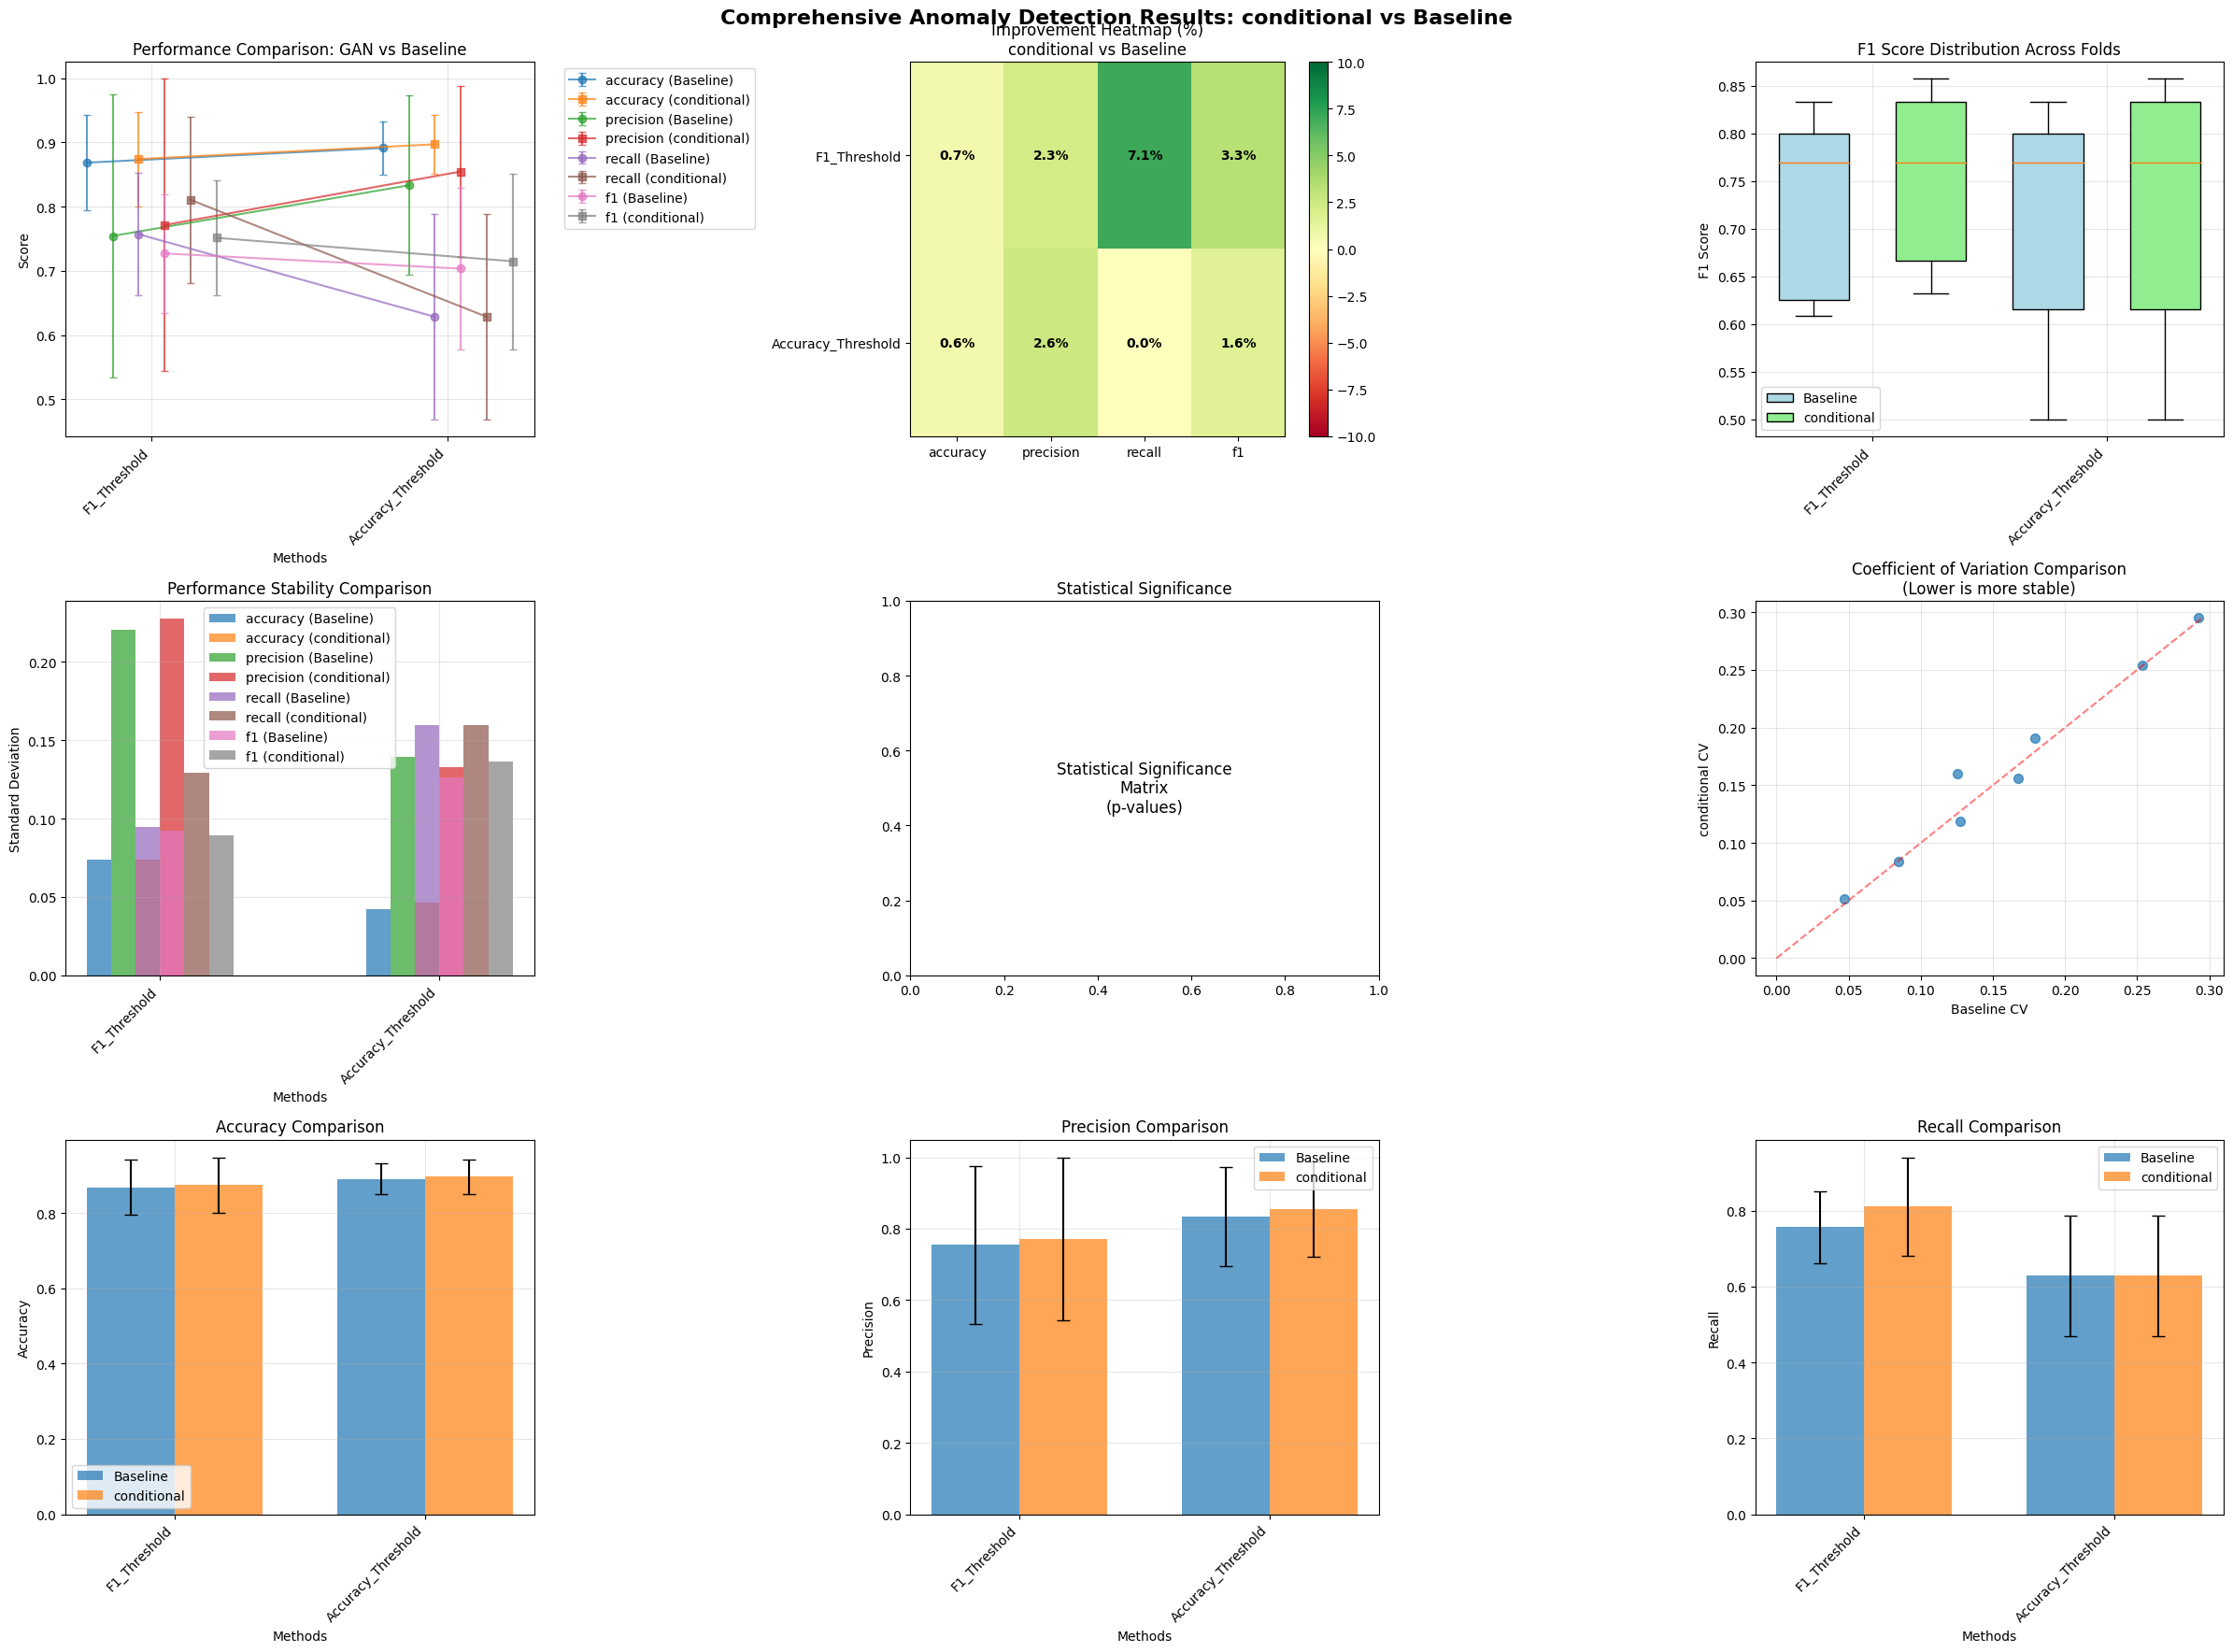


ENHANCED ANOMALY DETECTION RECOMMENDATIONS (conditional)

🏆 BEST METHODS WITH conditional:
   • Best F1 Score: F1_Threshold (0.7516 ± 0.0892)
   • Most Stable: F1_Threshold (CV = 0.1186)

📈 conditional EFFECTIVENESS:
   • F1_Threshold: 100% metrics improved, 0% significantly
   • Accuracy_Threshold: 75% metrics improved, 0% significantly

🎯 conditional OVERALL EFFECTIVENESS: Not Effective
   • 0/8 comparisons show significant improvement
   • Success Rate: 0.0%

📊 METHOD-SPECIFIC INSIGHTS:
   • F1_Threshold          : Performance Boost
   • Accuracy_Threshold    : Performance Boost

🎯 FINAL RECOMMENDATIONS:
   ❌ conditional data augmentation shows LIMITED benefit
   • Consider baseline methods or alternative GAN architectures
   • Current success rate: 0.0%

💡 DEPLOYMENT STRATEGY:
   • Stick with baseline methods for now
   • Investigate alternative data augmentation strategies
   • Consider ensemble methods combining multiple approaches



({'F1_Threshold': {'accuracy': {'mean': 0.8742857142857143,
    'std': 0.07362342129557212,
    'min': 0.7714285714285715,
    'max': 0.9428571428571428,
    'median': 0.9142857142857143,
    'values': [0.9428571428571428,
     0.8,
     0.9428571428571428,
     0.9142857142857143,
     0.7714285714285715]},
   'precision': {'mean': 0.7714285714285715,
    'std': 0.2276768207215604,
    'min': 0.5,
    'max': 1.0,
    'median': 0.8571428571428571,
    'values': [0.8571428571428571, 0.5, 1.0, 1.0, 0.5]},
   'recall': {'mean': 0.8107142857142857,
    'std': 0.12955969390869324,
    'min': 0.625,
    'max': 1.0,
    'median': 0.8571428571428571,
    'values': [0.8571428571428571,
     0.8571428571428571,
     0.7142857142857143,
     0.625,
     1.0]},
   'f1': {'mean': 0.7515905147484093,
    'std': 0.0891618755201766,
    'min': 0.631578947368421,
    'max': 0.8571428571428571,
    'median': 0.7692307692307693,
    'values': [0.8571428571428571,
     0.631578947368421,
     0.8333333333

In [5]:
run_comprehensive_cross_validation_experiment(X_test_normal, X_test_faulty, device, generated_data, batch_size=32, gan_type="conditional")